# **PurrPal: Prototipe Model Prediksi Penyakit Kucing Berdasarkan Gejala 🐾**

---

### **1. Tujuan Proyek**

Proyek PurrPal bertujuan untuk memberdayakan pemilik kucing di daerah terpencil Indonesia yang memiliki akses terbatas ke dokter hewan. Dengan memanfaatkan *machine learning*, kami membangun sebuah **alat bantu diagnosis awal** berdasarkan gejala yang dapat diamati, sehingga pemilik dapat mengambil langkah yang lebih cepat dan tepat untuk kesehatan hewan kesayangannya, sekaligus mengurangi beban emosional akibat ketidakberdayaan.

### **2. Objektif Notebook Ini**

Notebook ini merupakan implementasi teknis dari **fase pertama** proyek PurrPal, yaitu **pemodelan berbasis gejala**. Tujuannya adalah untuk membangun, melatih, dan mengevaluasi model klasifikasi yang dapat memprediksi kemungkinan penyakit kucing berdasarkan serangkaian gejala yang dilaporkan.

### **3. Alur Kerja**

Alur kerja yang akan dilalui dalam notebook ini meliputi:
* **Pemuatan & Pembersihan Data**: Mengimpor dataset dan membersihkan data mentah, termasuk menggabungkan nama penyakit yang sama.
* **Analisis Eksplorasi Data (EDA)**: Memahami distribusi data dan memilih penyakit target untuk pemodelan.
* **Rekayasa Fitur**: Mengubah data kualitatif (gejala) menjadi format numerik yang dapat dipahami oleh model.
* **Pra-pemrosesan & Augmentasi**: Melakukan *scaling* pada fitur numerik dan menyeimbangkan dataset dengan SMOTE.
* **Pelatihan & Evaluasi Model**: Melatih model *Random Forest* dan mengukur performanya secara kuantitatif.
* **Interpretasi & Penyimpanan**: Menganalisis fitur-fitur terpenting yang dipelajari model dan menyimpan artefak (model dan preprocessor) untuk implementasi di masa depan.

---
**Tanggal:** 10 Juni 2025  
**Versi Model:** 1.0 - Symptoms / RandomForest

# 1. Import Library

In [3]:
# Impor library utama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Impor komponen dari Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Impor SMOTE untuk augmentasi data
from imblearn.over_sampling import SMOTE

# Pengaturan visualisasi
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

# --- Konfigurasi Proyek ---
FILE_PATH = 'cleaned_animal_disease_prediction.csv'
TARGET_COLUMN = 'Disease_Prediction'

# 2. Memuat dan Membersihkan Data
Pada langkah ini, kita memuat dataset, memfilternya hanya untuk 'Kucing', dan membersihkan nama-nama penyakit yang sama untuk mengonsolidasikan data.

In [4]:
print("Memuat dan membersihkan data...")

# Muat dataset
try:
    df = pd.read_csv(FILE_PATH)
    print(f"Dataset awal berhasil dimuat dengan {df.shape[0]} baris.")
except FileNotFoundError:
    raise Exception(f"File tidak ditemukan di path: {FILE_PATH}")

# 1. Filter hanya untuk kucing
df_cat = df[df['Animal_Type'] == 'Cat'].copy()
print(f"Ditemukan {df_cat.shape[0]} data untuk kucing.")

# 2. Definisikan dan terapkan pemetaan nama penyakit yang sama
disease_map = {
    'Feline Upper Respiratory Infection': 'Upper Respiratory Infection',
    'Panleukopenia': 'Feline Panleukopenia',
    'Feline Leukemia': 'Feline Leukemia Virus',
    'Feline Rhinotracheitis': 'Feline Viral Rhinotracheitis'
}
df_cat[TARGET_COLUMN] = df_cat[TARGET_COLUMN].replace(disease_map)
print("Nama-nama penyakit yang sama berhasil digabungkan.")

Memuat dan membersihkan data...
Dataset awal berhasil dimuat dengan 431 baris.
Ditemukan 72 data untuk kucing.
Nama-nama penyakit yang sama berhasil digabungkan.


# 3. Analisis Eksplorasi Data (EDA) & Pemilihan Target

Kita akan memvisualisasikan distribusi penyakit setelah pembersihan untuk memutuskan penyakit mana yang akan menjadi target model kita. Kita memilih penyakit dengan jumlah kasus yang cukup agar model dapat belajar dengan baik.

Melakukan analisis dan pemilihan penyakit target...


/var/folders/mx/m33wtfwn5qg_ph19pb31z1nh0000gn/T/ipykernel_92150/901062262.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=disease_counts.index, x=disease_counts.values, palette='viridis')


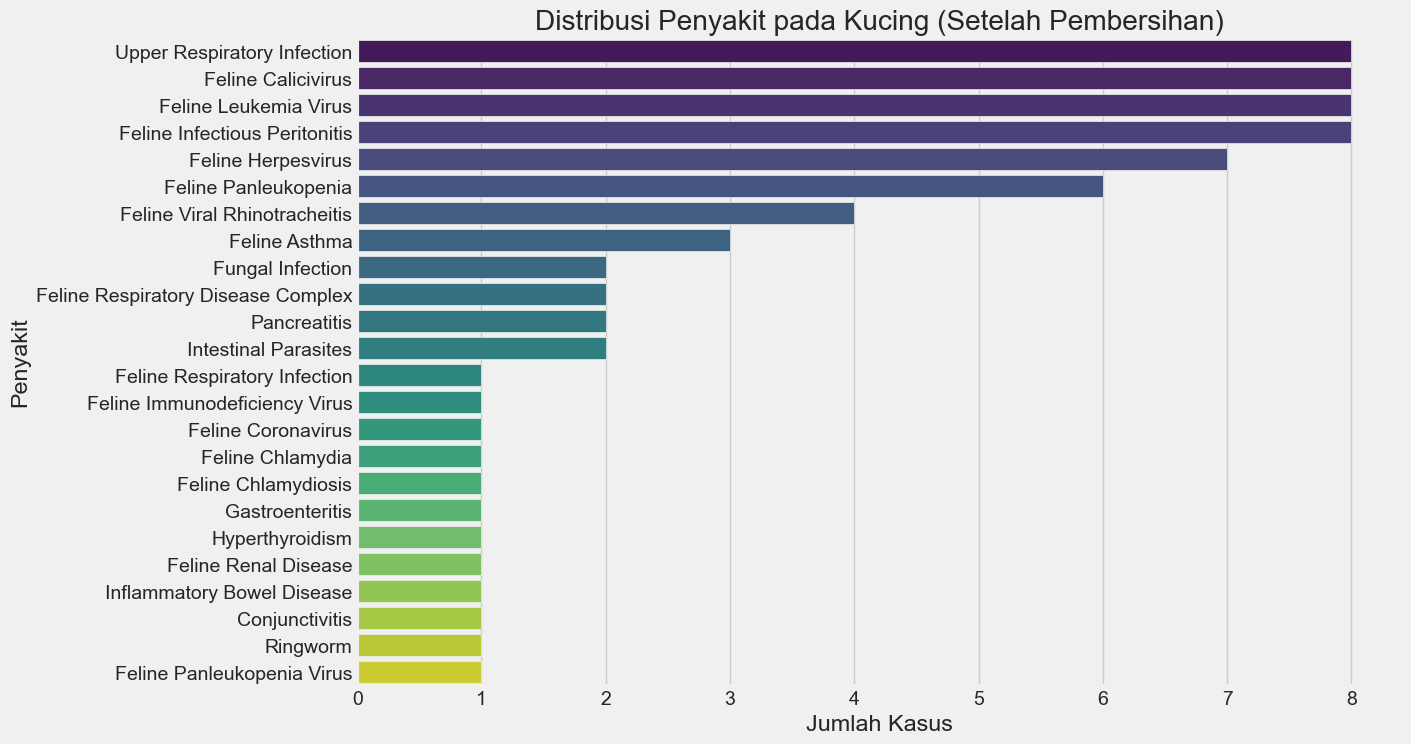


Penyakit yang akan digunakan sebagai target (>= 6 kasus):
['Upper Respiratory Infection', 'Feline Calicivirus', 'Feline Leukemia Virus', 'Feline Infectious Peritonitis', 'Feline Herpesvirus', 'Feline Panleukopenia']

Bentuk data final untuk pemodelan: 45 baris dan 22 kolom.


In [5]:
print("Melakukan analisis dan pemilihan penyakit target...")

# Hitung jumlah kasus per penyakit setelah digabungkan
disease_counts = df_cat[TARGET_COLUMN].value_counts()

# Visualisasi
plt.figure(figsize=(12, 8))
sns.barplot(y=disease_counts.index, x=disease_counts.values, palette='viridis')
plt.title('Distribusi Penyakit pada Kucing (Setelah Pembersihan)')
plt.xlabel('Jumlah Kasus')
plt.ylabel('Penyakit')
plt.show()

# Pilih penyakit dengan jumlah kasus >= 6 sebagai target
MINIMUM_CASES = 6
top_diseases = disease_counts[disease_counts >= MINIMUM_CASES].index.tolist()
df_model = df_cat[df_cat[TARGET_COLUMN].isin(top_diseases)].copy()

print(f"\nPenyakit yang akan digunakan sebagai target (>= {MINIMUM_CASES} kasus):")
print(top_diseases)
print(f"\nBentuk data final untuk pemodelan: {df_model.shape[0]} baris dan {df_model.shape[1]} kolom.")

# 4. Rekayasa Fitur (Feature Engineering)

Ini adalah langkah krusial di mana kita mengubah data mentah menjadi format numerik yang dapat dipahami oleh model. Kita akan mengubah semua kolom gejala menjadi format biner (0 atau 1).

In [6]:
print("Memulai rekayasa fitur...")

# 1. Gabungkan semua gejala unik dari kolom Symptom 1-4
symptoms_cols = ['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4']
all_symptoms = set(s for col in symptoms_cols for s in df_model[col].unique() if s != 'No')

# 2. Buat kolom biner untuk setiap gejala dari Symptom 1-4
for symptom in all_symptoms:
    df_model[symptom] = df_model[symptoms_cols].apply(lambda row: 1 if symptom in row.values else 0, axis=1)

# 3. Ubah kolom gejala biner (Ya/Tidak) menjadi 1/0
binary_symptom_cols = ['Appetite_Loss', 'Vomiting', 'Diarrhea', 'Coughing', 'Labored_Breathing',
                       'Lameness', 'Skin_Lesions', 'Nasal_Discharge', 'Eye_Discharge']
for col in binary_symptom_cols:
    df_model[col] = df_model[col].apply(lambda x: 1 if x == 'Yes' else 0)

# 4. Bersihkan dan buat fitur numerik/kategorikal lainnya
df_model['Body_Temperature'] = df_model['Body_Temperature'].str.replace('°C', '').astype(float)
df_model['Duration_days'] = df_model['Duration'].str.extract('(\d+)').astype(int)
df_model.loc[df_model['Duration'].str.contains('week', na=False), 'Duration_days'] *= 7
df_model['Gender_Male'] = df_model['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

# 5. Buat dataframe final dengan menghapus kolom-kolom asli yang tidak lagi dibutuhkan
cols_to_drop = ['Animal_Type', 'Breed', 'Gender', 'Duration'] + symptoms_cols
df_final = df_model.drop(columns=cols_to_drop)
df_final = df_final.loc[:,~df_final.columns.duplicated()]

print("Rekayasa fitur selesai.")
df_final.head()

Memulai rekayasa fitur...
Rekayasa fitur selesai.


<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
/var/folders/mx/m33wtfwn5qg_ph19pb31z1nh0000gn/T/ipykernel_92150/2193674301.py:19: SyntaxWarning: invalid escape sequence '\d'
  df_model['Duration_days'] = df_model['Duration'].str.extract('(\d+)').astype(int)


,Age,Weight,Appetite_Loss,Vomiting,Diarrhea,Coughing,Labored_Breathing,Lameness,Skin_Lesions,Nasal_Discharge,...,Dehydration,Lethargy,Weight Loss,Fever,Appetite Loss,Loss of Appetite,Nasal Discharge,Skin Lesions,Duration_days,Gender_Male
1,2,4.5,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,7,0
10,3,5.0,1,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,5,0
12,1,4.2,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,3,1
19,5,4.8,0,0,0,0,1,0,0,1,...,0,1,0,0,1,0,1,0,7,0
23,3,5.5,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,3,1


# 5. Persiapan Data untuk Model (Split Data)

Kita memisahkan data menjadi set fitur (X) dan target (y), lalu membaginya lagi menjadi data latih (train) dan data uji (test).

In [7]:
print("Membagi data menjadi set training dan testing...")

# Pisahkan fitur (X) dan target (y)
X = df_final.drop(TARGET_COLUMN, axis=1)
y = df_final[TARGET_COLUMN]

# Bagi data dengan stratifikasi untuk menjaga proporsi kelas di kedua set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Data dibagi menjadi: {X_train.shape[0]} untuk training dan {X_test.shape[0]} untuk testing.")

Membagi data menjadi set training dan testing...
Data dibagi menjadi: 33 untuk training dan 12 untuk testing.


# 6. Membuat Pipeline Pra-pemrosesan

Ini adalah peningkatan utama. Kita menggunakan ColumnTransformer untuk menerapkan scaling hanya pada kolom numerik. 

In [8]:
print("Membuat pipeline pra-pemrosesan...")

# Identifikasi kolom numerik yang perlu di-scale
numeric_features = ['Age', 'Weight', 'Body_Temperature', 'Duration_days', 'Heart_Rate']

# Buat preprocessor dengan ColumnTransformer
# Kolom numerik akan di-scale, sisanya (gejala biner) akan dibiarkan apa adanya ('passthrough')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

# Terapkan preprocessor ke data
# Fit dan transform pada data training
X_train_processed = preprocessor.fit_transform(X_train)
# Hanya transform pada data testing
X_test_processed = preprocessor.transform(X_test)

print("Pra-pemrosesan dengan ColumnTransformer selesai.")

Membuat pipeline pra-pemrosesan...
Pra-pemrosesan dengan ColumnTransformer selesai.


# 7. Augmentasi Data (SMOTE) dengan k_neighbors Dinamis

Karena dataset kita tidak seimbang, kita menggunakan SMOTE untuk menyeimbangkan data latih. Kita menghitung k_neighbors secara dinamis agar notebook tidak error jika jumlah sampel kelas minoritas sangat kecil.

In [9]:
print("Menyeimbangkan data training dengan SMOTE...")

# Hitung jumlah sampel di kelas minoritas terkecil dalam data training
min_class_count = y_train.value_counts().min()

# Tentukan k_neighbors secara dinamis (harus lebih kecil dari jumlah sampel kelas minoritas)
# Jika min_class_count = 1, SMOTE tidak bisa jalan. Kita batasi minimal k=1.
k = max(1, min_class_count - 1)
print(f"Jumlah sampel kelas minoritas: {min_class_count}. Menggunakan k_neighbors = {k} untuk SMOTE.")

# Inisialisasi dan terapkan SMOTE
smote = SMOTE(random_state=42, k_neighbors=k)
X_train_sm, y_train_sm = smote.fit_resample(X_train_processed, y_train)

print(f"Ukuran data training setelah SMOTE: {X_train_sm.shape}")
print("\nDistribusi kelas setelah SMOTE:")
print(pd.Series(y_train_sm).value_counts())

Menyeimbangkan data training dengan SMOTE...
Jumlah sampel kelas minoritas: 4. Menggunakan k_neighbors = 3 untuk SMOTE.
Ukuran data training setelah SMOTE: (36, 25)

Distribusi kelas setelah SMOTE:
Disease_Prediction
Feline Panleukopenia             6
Feline Infectious Peritonitis    6
Upper Respiratory Infection      6
Feline Leukemia Virus            6
Feline Herpesvirus               6
Feline Calicivirus               6
Name: count, dtype: int64


# 8. Melatih Model Klasifikasi

Sekarang data kita sudah siap. Kita akan melatih model RandomForestClassifier pada data training yang telah diproses dan diseimbangkan.

In [10]:
print("Melatih model Random Forest Classifier...")

# Inisialisasi model
# class_weight='balanced' membantu menangani ketidakseimbangan jika masih ada
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Latih model
model.fit(X_train_sm, y_train_sm)

print("Model berhasil dilatih.")

Melatih model Random Forest Classifier...
Model berhasil dilatih.


# 9. Evaluasi Performa Model

Kita akan menggunakan model yang telah dilatih untuk membuat prediksi pada data uji (yang belum pernah dilihat sebelumnya) dan mengevaluasi performanya.

Mengevaluasi performa model pada data testing...

Laporan Klasifikasi Model:

                               precision    recall  f1-score   support

           Feline Calicivirus       0.33      1.00      0.50         2
           Feline Herpesvirus       0.00      0.00      0.00         2
Feline Infectious Peritonitis       1.00      0.50      0.67         2
        Feline Leukemia Virus       0.00      0.00      0.00         2
         Feline Panleukopenia       1.00      0.50      0.67         2
  Upper Respiratory Infection       1.00      0.50      0.67         2

                     accuracy                           0.42        12
                    macro avg       0.56      0.42      0.42        12
                 weighted avg       0.56      0.42      0.42        12


Confusion Matrix:


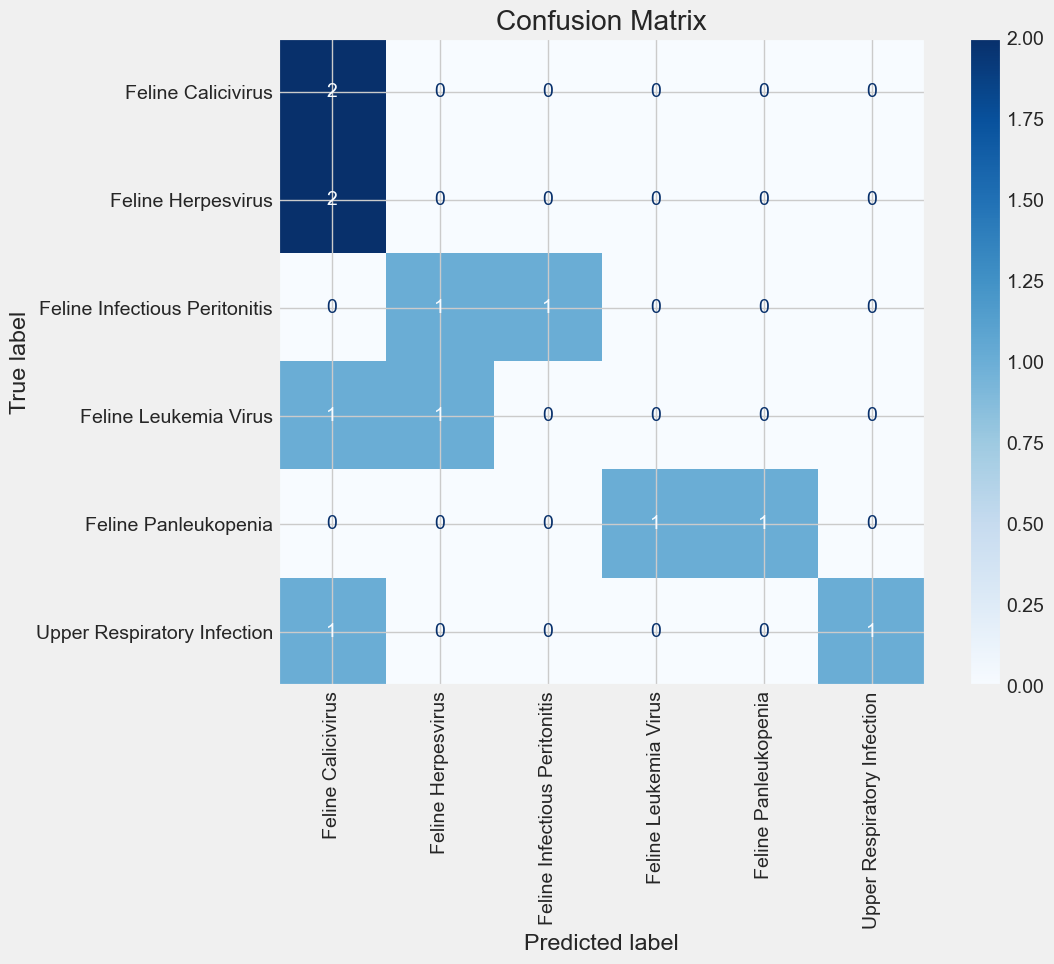

In [11]:
print("Mengevaluasi performa model pada data testing...")

# Lakukan prediksi pada data test yang sudah diproses
y_pred = model.predict(X_test_processed)

# Tampilkan laporan klasifikasi
print("\nLaporan Klasifikasi Model:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Tampilkan Confusion Matrix
print("\nConfusion Matrix:")
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(model, X_test_processed, y_test,
                                      ax=ax, cmap='Blues',
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

# 10. Interpretasi Model (Fitur Paling Penting)

Bagian ini sangat penting untuk memahami mengapa model membuat keputusan tertentu. Kita akan melihat gejala mana yang paling berpengaruh.

Menganalisis fitur terpenting yang digunakan model...


/var/folders/mx/m33wtfwn5qg_ph19pb31z1nh0000gn/T/ipykernel_92150/2925436826.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='rocket')


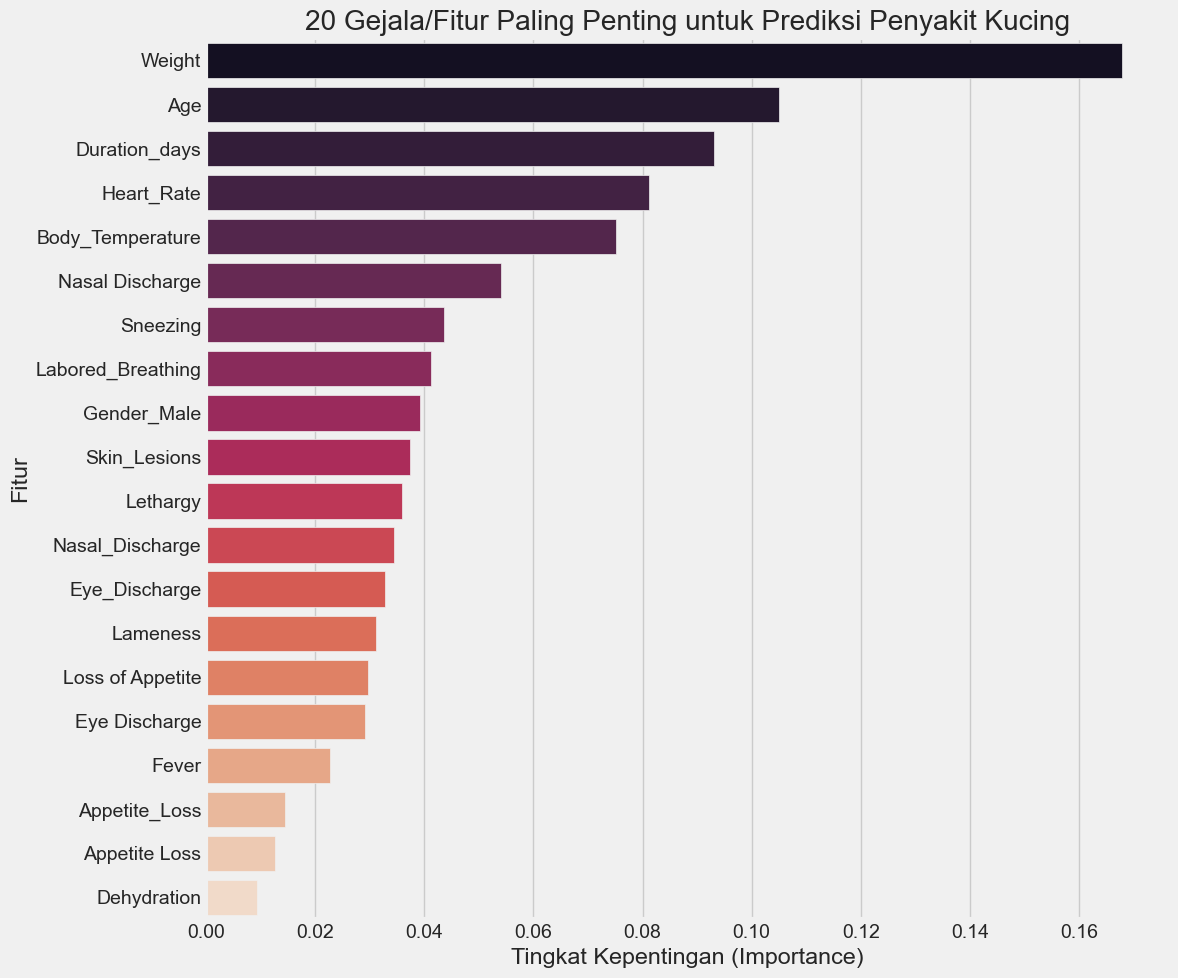


Fitur paling berpengaruh menurut model:
              feature  importance
1              Weight    0.167955
0                 Age    0.105012
3       Duration_days    0.093167
4          Heart_Rate    0.081135
2    Body_Temperature    0.075095
22    Nasal Discharge    0.053979
15           Sneezing    0.043520
9   Labored_Breathing    0.041167
24        Gender_Male    0.039131
11       Skin_Lesions    0.037427
17           Lethargy    0.035824
12    Nasal_Discharge    0.034448
13      Eye_Discharge    0.032832
10           Lameness    0.031048
21   Loss of Appetite    0.029582
14      Eye Discharge    0.029109
19              Fever    0.022715
5       Appetite_Loss    0.014500
20      Appetite Loss    0.012589
16        Dehydration    0.009370


In [12]:
print("Menganalisis fitur terpenting yang digunakan model...")

# Dapatkan nama fitur setelah diproses oleh ColumnTransformer
# Urutannya: fitur numerik yang di-scale, lalu sisa fitur yang di-passthrough
passthrough_features = [col for col in X_train.columns if col not in numeric_features]
processed_feature_names = numeric_features + passthrough_features

# Buat dataframe feature importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': processed_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(20)

# Visualisasi
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='rocket')
plt.title('20 Gejala/Fitur Paling Penting untuk Prediksi Penyakit Kucing')
plt.xlabel('Tingkat Kepentingan (Importance)')
plt.ylabel('Fitur')
plt.tight_layout()
plt.show()

print("\nFitur paling berpengaruh menurut model:")
print(feature_importance_df)

# 11. Menyimpan Artefak Model untuk Implementasi

Ini adalah langkah terakhir. Kita menyimpan preprocessor (yang berisi scaler) dan model yang sudah dilatih. File-file ini nantinya dimuat di aplikasi PurrPal untuk membuat prediksi nyata.

In [13]:
print("Menyimpan model dan preprocessor untuk implementasi...")

MODEL_TYPE = 'symptoms'
ALGORITHM_NAME = 'rf' # rf untuk RandomForest

# Definisikan nama file yang baru
PREPROCESSOR_FILE = f'purrpal_{MODEL_TYPE}_{ALGORITHM_NAME}_preprocessor.joblib'
MODEL_FILE = f'purrpal_{MODEL_TYPE}_{ALGORITHM_NAME}_model.joblib'
CLASS_NAMES_FILE = f'purrpal_{MODEL_TYPE}_{ALGORITHM_NAME}_class_names.joblib'

# Simpan objek-objek
joblib.dump(preprocessor, PREPROCESSOR_FILE)
joblib.dump(model, MODEL_FILE)
joblib.dump(model.classes_, CLASS_NAMES_FILE) # Simpan nama kelas untuk referensi

print("Artefak berhasil disimpan dengan nama baru yang lebih detail:")
print(f"- Preprocessor: {PREPROCESSOR_FILE}")
print(f"- Model: {MODEL_FILE}")
print(f"- Nama Kelas: {CLASS_NAMES_FILE}")

Menyimpan model dan preprocessor untuk implementasi...
Artefak berhasil disimpan dengan nama baru yang lebih detail:
- Preprocessor: purrpal_symptoms_rf_preprocessor.joblib
- Model: purrpal_symptoms_rf_model.joblib
- Nama Kelas: purrpal_symptoms_rf_class_names.joblib
